# Detecting Outliers with Cleanlab and PyTorch Image Models (timm)

This 5-minute tutorial shows how to detect outliers in image data using Cleanlab and PyTorch. We use the **cifar10** dataset where each image belongs to 1 of 10 classes: `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]`. You can easily replace the image dataset + neural network used here with any other Pytorch dataset + neural network (e.g. to instead detect outliers in text data). 

**Overview of what we'll do in this tutorial:**

- Pre-process [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) to create a Pytorch dataset.
- Create `train_data` and `test_data` such that `train_data` only contains images of animals and `test_data` contains images from all classes.
- Load pretrained `timm` neural network model and extract `train_data` and `test_data` feature embeddings from its representations.
- Use `cleanlab` to find naturally occurring outlier examples in the `train_data` (i.e. atypical images).
- Find outlier examples in the `test_data` that do not stem from training data distribution (including out-of-distribution non-animal images).
- Explore threshold selection for determining which images are outliers vs not.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have numeric feature embeddings for your data? Just run the code below to compute outlier scores.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.rank import get_outlier_scores
    
# To get outlier scores for train_data using feature matrix train_feature_embeddings
outlier_scores, knn = get_outlier_scores(features=train_feature_embeddings, return_estimator=True)

# To get outlier scores for additional test_data using feature matrix test_feature_embeddings
test_outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn)
    
    
```
    
</div>
</div>

## 1. Install the required dependencies
You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib sklearn torch torchvision timm
!pip install cleanlab
...
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)
# Package versions we used: matplotlib==3.5.1, torch==1.11.0, torchvision==0.12.0, timm==0.5.4

dependencies = ["matplotlib", "torch", "torchvision", "sklearn", "timm", "cleanlab"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install git+https://github.com/cleanlab/cleanlab.git@8371edffc90290a84b7c929df282b85799d25c73
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

2022-09-06 16:38:49.283573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.8.13/x64/lib
2022-09-06 16:38:49.283614: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Let's first import the required packages and set some seeds for reproducibility

In [2]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import warnings

import cleanlab
from cleanlab.rank import get_outlier_scores
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import NearestNeighbors # import KNN estimator
from sklearn.model_selection import train_test_split

import timm # resnet50 pre-trained model

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Pre-process the Cifar10 dataset

After loading the data and processing the images, we manually remove some classes from the training dataset thereby making images from these classes outliers in the test set. For this example we've chosen to remove all classes that are not an animal, such that images from the following classes are considered out-of-distribution: `[airplane, automobile, ship, truck]`.

In [3]:
# Load cifar10 images into tensors for training (rescales pixel values to [0,1] interval):
transform_normalize = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_normalize)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_normalize)

# Remove non-animal images from the training dataset
animal_classes = [2,3,4,5,6,7]  # which labels correspond to images of animals
animal_idxs = np.where(np.isin(train_data.targets, animal_classes))[0]

# Only work with small subset of each dataset to speedup tutorial
train_idxs = np.random.choice(animal_idxs, len(animal_idxs) // 6, replace=False)
test_idxs = np.random.choice(range(len(test_data)), len(test_data) // 10, replace=False)

train_data  = torch.utils.data.Subset(train_data, train_idxs)  # select subset of animal images for train_data
test_data  = torch.utils.data.Subset(test_data, test_idxs)  # select subset of all images for test_data
print('train_data length: %s' % (len(train_data)))
print('test_data length: %s' % (len(test_data)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


train_data length: 5000
test_data length: 1000


#### Visualize some of the training and test examples

In [4]:
txt_classes = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = dataset[i]
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_classes[int(y)])
        ax.imshow(imshow(X))
    plt.show()

Observe how there are only animals left in the training set `train_data` below.

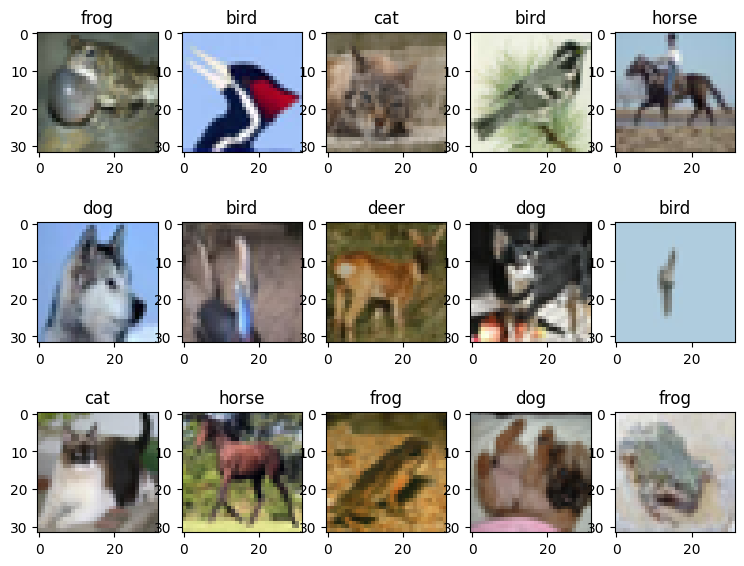

In [5]:
plot_images(train_data)

The test set on the other hand still visibily contains the non-animal images from classes like `[ship, airplane, automobile, truck]`. If we consider `train_data` to be representative of the typical data distribution, then these non-animal images in `test_data` become outliers.

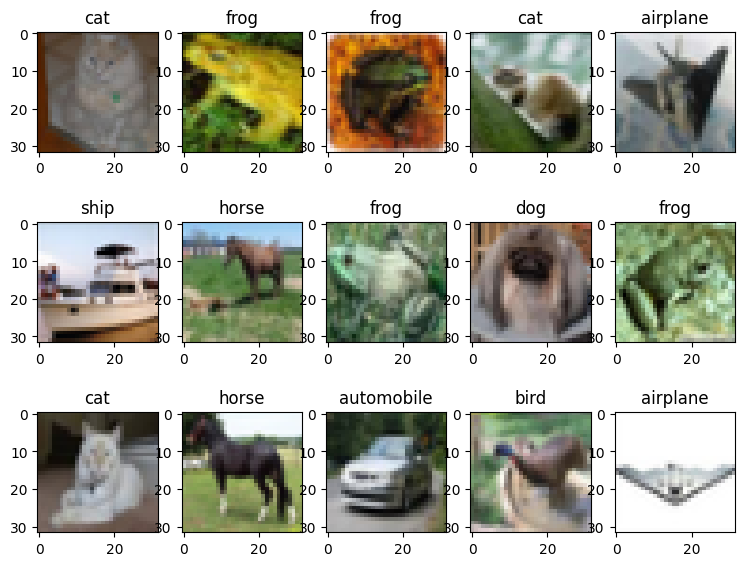

In [6]:
plot_images(test_data)

## 3. Represent each image as feature embeddings

We construct a neural network and pass images through the network to generate vector embeddings via its hidden layer representation. Here we import a `resnet50` network from [timm](https://timm.fast.ai/), where this model has been pretrained on a large corpus of other images. 

Note that cleanlab's outlier detection can be applied to feature embeddings generated from any model (or to the raw data features if they are already numeric vectors). Outlier detection works best with moderately-dimensional feature vectors, in which values along each dimension are of a similar scale. 

In [7]:
# Function to generate 2048-dimensional feature embeddings from images
def embed_images(model, dataloader):
    feature_embeddings = []

    for data in dataloader:
        images, labels = data
        with torch.no_grad():
            embeddings = model(images)
            feature_embeddings.extend(embeddings.numpy())
    feature_embeddings = np.array(feature_embeddings)
    return feature_embeddings  # each row corresponds to embedding of a different image

In [8]:
# Download neural network from timm
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Create dataloaders efficiently streaming images through the network
batch_size = 50
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Generate feature embeddings of the training data using the model
train_feature_embeddings = embed_images(model, trainloader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')

# Generate feature embeddings of the test data using the model
test_feature_embeddings = embed_images(model, testloader)
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/runner/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Train embeddings pooled shape: (5000, 2048)


Test embeddings pooled shape: (1000, 2048)


## 4. Use cleanlab to find outliers in the dataset

#### Scoring outliers in training data

Calling cleanlab's ``get_outlier_score()`` on ``train_feature_embeddings`` will find any naturally occuring outliers in ``train_data``. These examples are atypical images that look strange or different from the majority of examples in the dataset. In our case, these correspond to odd-looking images of animals that do not resemble typical animals depicted in **cifar10**. This method produces a score in [0,1] for each example, where lower values correspond to more atypical examples (more likely out-of-distribution).

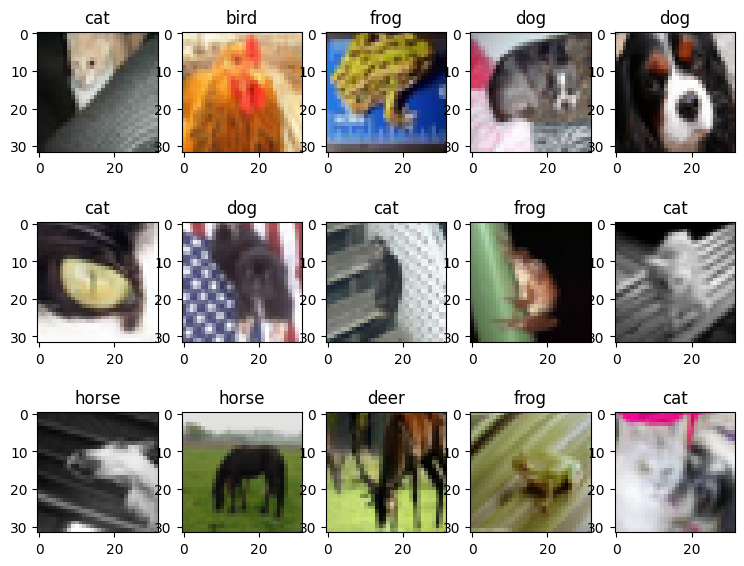

In [9]:
# Get outlier scores for each of our train_data feature embeddings
train_outlier_scores, knn = get_outlier_scores(features=train_feature_embeddings, return_estimator=True)

# View images with top 15 outlier scores
top_train_outlier_idxs = train_outlier_scores.argsort()[:15]
top_train_outlier_subset = torch.utils.data.Subset(train_data, top_train_outlier_idxs)
plot_images(top_train_outlier_subset)

For fun, let's see what `cleanlab` considers the least likely outliers in the training data! These examples look very homogeneous as each one is highly similar to many other training images.

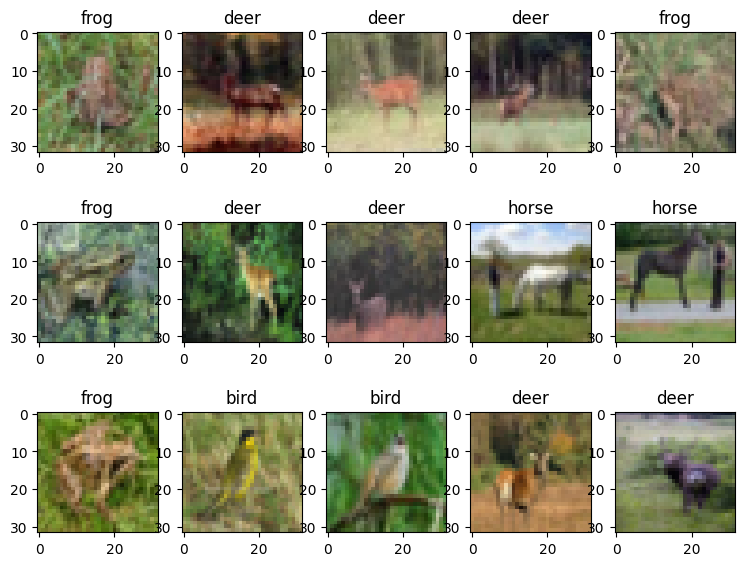

In [10]:
# Visualize 15 least likely outliers in train_data
bottom_train_outlier_idxs = (-train_outlier_scores).argsort()[:15]
bottom_train_outlier_subset = torch.utils.data.Subset(train_data, bottom_train_outlier_idxs)
plot_images(bottom_train_outlier_subset)

#### Scoring outliers in additional test data

Now suppose we want to find outlier images in our additional test data, in particular images unlikely to stem from the same distribution as the training data. We can again use `get_outlier_scores()` this time passing in the previously-fitted estimator `knn` used to measure similarity between training examples.

In [11]:
test_outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn)

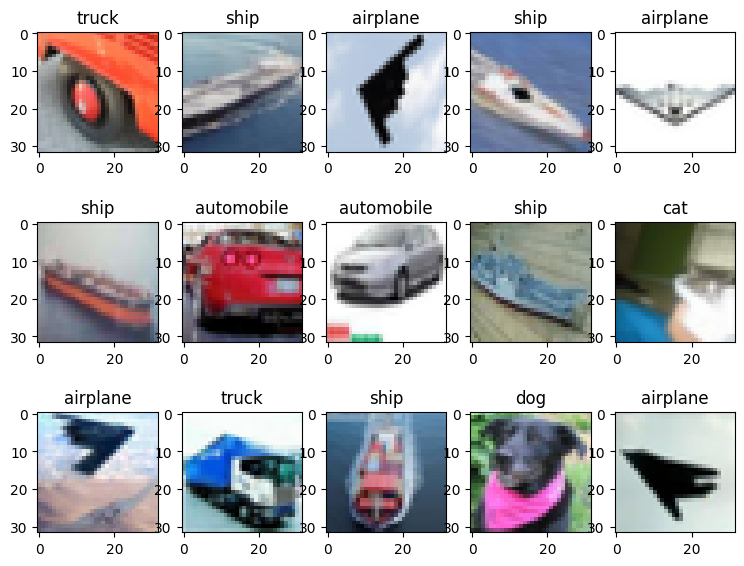

In [12]:
# Visualize top 15 most severe outliers in test data
top_outlier_idxs = (test_outlier_scores).argsort()[:15]
top_outlier_subset = torch.utils.data.Subset(test_data, top_outlier_idxs)
plot_images(top_outlier_subset)

Notice how almost all outliers identified in `test_data` belong to (non-animal) classes not present in the training data. These non-animal images have very different feature embeddings than the training images which are all animals.

#### Evaluating out of distribution detection performance 

Since we have access to ground-truth labels here (which is not necessary for outlier detection with cleanlab), 
we can evaluate our outlier scores for out-of-distribution detection, in which the goal is to find test images whose label does not correspond to any of the classes in the training data. We plot the precision/recall achieved by our outlier scores for the test data (which is a mix of animal and non-animal images).

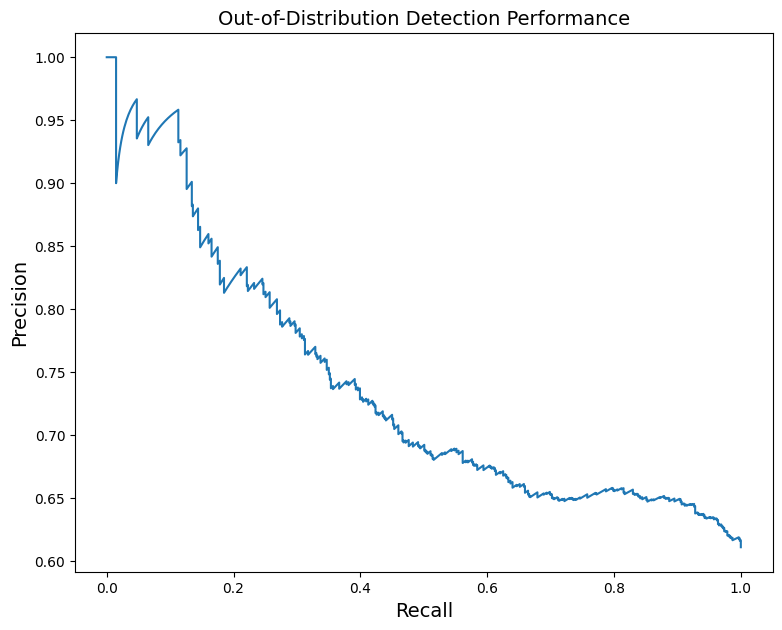

In [13]:
test_data_labels = np.array(test_data.dataset.targets) # Get subset labels from out test_data
animal_idxs = np.where(np.isin(test_data_labels[test_data.indices], animal_classes))[0] # Find animal idxs
not_outlier = np.zeros(len(test_data), dtype=bool)
not_outlier[animal_idxs] = True
precision, recall, thresholds = precision_recall_curve(not_outlier, test_outlier_scores)

plt.plot(recall, precision)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Out-of-Distribution Detection Performance", fontsize=14)
plt.show()

#### Deciding which test examples are outliers

Given outlier scores, how do we determine how many of the top-ranked examples in ``test_data`` should be marked as outliers? 

Inevitably this has some true positive / false positive trade-off, so let's suppose we want to ensure around at most 5% false positives. We can use the 5-th percentile of the distribution of `train_outlier_scores` (assuming the training data are in-distribution examples without outliers) as a hard score threshold below which to consider a test example an outlier.

Let's compute the 5th percentile of the training outlier score distribution (shown as red line).

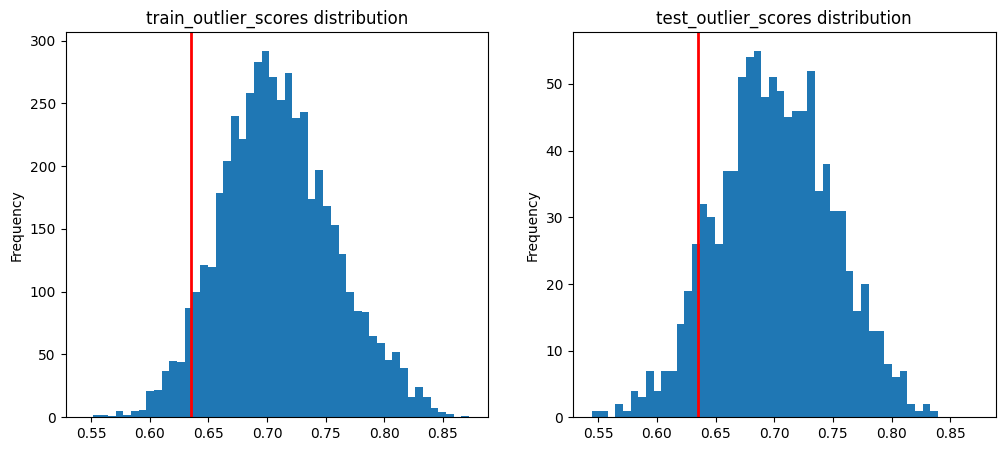

In [14]:
fifth_percentile = np.percentile(train_outlier_scores, 5)  # 5th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(train_outlier_scores.min(),test_outlier_scores.min()), \
             max(train_outlier_scores.max(),test_outlier_scores.max())]
axes[0].hist(train_outlier_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=fifth_percentile, color='red', linewidth=2)
axes[1].hist(test_outlier_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=fifth_percentile, color='red', linewidth=2)

plt.show()

All test examples whose `test_outlier_scores` fall left of the red line will be marked as an outlier.

Let's plot the least-certain outliers of our `test_data`. These are the images immediately to the left of that cutoff threshold (red line). The majority of them are still truly out-of-distribution non-animal images, but there are a few atypical-looking animals that are now erroneously identified as outliers as well.

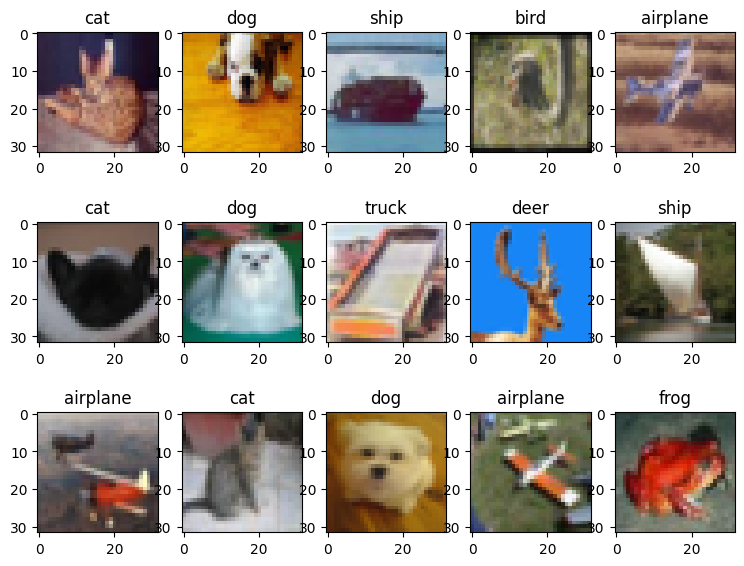

In [15]:
# Visualize 15 images with outlier scores right along the cuttoff (i.e. those images we've identified as outliers that we're least sure about)
sorted_idxs = test_outlier_scores.argsort()
outlier_scores = test_outlier_scores[sorted_idxs]
outlier_indices = sorted_idxs[outlier_scores < fifth_percentile]  # Images in test data flagged as outliers

selected_outlier_subset = torch.utils.data.Subset(test_data, outlier_indices[::-1])
plot_images(selected_outlier_subset)

#### How does cleanlab detect outliers?

Outlier scores are defined relative to the average distance (computed over feature values) between each example and its K nearest neighbors in the training data. Such scores have been found to be particularly effective for out-of-distribution detection, see this paper for more details:

[Back to the Basics: Revisiting Out-of-Distribution Detection Baselines](https://arxiv.org/abs/2207.03061)


Internally, `cleanlab` uses the `sklearn.neighbors.NearestNeighbor` class (with *cosine* distance) to find the K nearest neighbors, but you can easily use another KNN estimator with `get_outlier_scores()`. Note that this class by default utilizes the *minkowski* distance, but we recommend using *cosine* distance between neural net representations of data.
</div>

In [16]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# Verify the top identified test outliers data are mostly non-animal images
num_animals = len([i for i in range(len(top_outlier_subset)) if top_outlier_subset[i][1] in animal_classes])
if 1 - (num_animals / len(top_outlier_subset)) < 0.81:
    raise Exception("Not enough non-animal images amongst top-ranked outliers in test_data.")